# Analysis of University tuition vs Potential Income

##Robert Zhang and Steven Chen

## Introduction

Higher education may be the default next-step to take for most high school students in the 2020's, but is it worth it? 

Some may argue that attending college is simpling not worth the pricy tuition and the precious 4-years in the most important years of a young adult's life. To analyze the validaty of this statement, this tutorial will walk you through the data science pipeline, starting from data collection to data cleaning, data visualization, modeling, and conclusions.

In this tutorial, we aim to analyze the relationship between college tuition, college ranking, and potential salaries after graduation.

## Sources and Setup

We decide to gather potential entry-level and mid-carrer salary data from [salary.com](https://www.payscale.com/college-salary-report/bachelors/page/1), which also contains data regarding percentage of alumnis whos says their work make the world a better place.

We gathered tuition data from The [Chronicle of Higher Education](https://www.chronicle.com/article/tuition-and-fees-1998-99-through-2018-19/), which contains data on annual in-state tuition, out-of-state tuition, and room and board fees.

We begin the setup process by importing libraries. The main libraries we will be using are pandas, request, BeaultifulSoup, numpy, matplotlib, and sklearn. We will use pandas dataframes to store and manage our data mainly in the data collection and cleaning stages. Numpy will mostly be used in the data cleaning process to edit and parse data. Matplotlib will be responsible for providing functions that enables data visualization. Finally, we will use sklearn to fit linear regression models on the data

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sma
warnings.filterwarnings('ignore')

## Data Collection

We begin our data collection process with collecting data from [payscale.com](https://www.payscale.com/college-salary-report/bachelors/page/1). We observed that the desired data resides in 63 webpages with unique urls. To collect the entire dataset, we decided to first create a dataframe using the data from the first page, and append the data from the following pages to the same data frame.


We first fetch the data of hte first page by using http request. After parsing the result of the http request using BeautifulSoup and saving it to the variable soup, we print out soup.prettify() to identify the table which our desired data resides in. In this case, we were able to successfully identify that the table has class='data-table'. After identifiying the table name, we use soup.find to save the table for later use.

In [ ]:
url = 'https://www.payscale.com/college-salary-report/bachelors/page/1'
# http request and parsing
r = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser')
# Finding desired table
table = soup.find('table', {'class':'data-table'})

We then use the read_html function in the pandas library to construct a dataframe based on the html table and assign appropriate column names

In [ ]:
# Creating dataframe
tables = pd.read_html(str(table))
salary = tables[0]

# Assign column names
salary.columns = ["Rank", "School Name", "School Type", "Early Career Pay", "Mid-Career Pay", "% High Meaning", "% STEM Degrees"]

Then, we use Literal String Interpolation, also known as F-strings inside a for loop to dynamically generate urls for pages 2-63 and repeat the previous steps to generate similar dataframes. After generating a dataframe for a page, we append the data to the master dataframe called salary

In [ ]:
for p in range(2, 63):

    # Dynamically generated url"
    r = requests.get(url)
    url = f"https://www.payscale.com/college-salary-report/bachelors/page/{p}"
    soup = BeautifulSoup(r.text, 'html.parser')

    table = soup.find('table', {'class':'data-table'})
    tables = pd.read_html(str(table))
    page = tables[0]

    page.columns = ["Rank", "School Name", "School Type", "Early Career Pay", "Mid-Career Pay", "% High Meaning", "% STEM Degrees"]

    # Append data from current page to the master dataframe
    salary = pd.concat([salary, page])

salary.head()

,Rank,School Name,School Type,Early Career Pay,Mid-Career Pay,% High Meaning,% STEM Degrees
0,Rank:1,School Name:Massachusetts Institute of Technology,"School Type:Engineering, Private School, Resea...","Early Career Pay:$93,700","Mid-Career Pay:$167,200",% High Meaning:51%,% STEM Degrees:68%
1,Rank:2,School Name:Harvey Mudd College,"School Type:Engineering, Liberal Arts School, ...","Early Career Pay:$97,700","Mid-Career Pay:$166,600",% High Meaning:56%,% STEM Degrees:75%
2,Rank:3,School Name:Princeton University,"School Type:Ivy League, Private School, Resear...","Early Career Pay:$81,800","Mid-Career Pay:$161,500",% High Meaning:48%,% STEM Degrees:49%
3,Rank:4,School Name:United States Naval Academy,"School Type:Engineering, Liberal Arts School, ...","Early Career Pay:$83,700","Mid-Career Pay:$160,100",% High Meaning:61%,% STEM Degrees:57%
4,Rank:5,School Name:Stanford University,"School Type:Engineering, Private School, Resea...","Early Career Pay:$87,100","Mid-Career Pay:$156,500",% High Meaning:55%,% STEM Degrees:50%


Then, we begin to collect data from The [Chronicle of Higher Education](https://www.chronicle.com/article/tuition-and-fees-1998-99-through-2018-19/). Due to complications from the website requiring login and subscription, we accessed the webpage that displays the data using a free article given when signing up for an account and saved the html file to access locally.

This time, we use BeautifulSoup to parse the downloaded html file and repeated the steps of viewing the html file to identify target table name and use soup.find to save it to a variable. Then we use the function pd.read_html like before to create a dataframe containing the data.

In [ ]:
soup = BeautifulSoup(open("tuition_page.html", encoding="utf8"), 'html.parser')

table = soup.find('table', {'class':'interactive_table'})
tables = pd.read_html(str(table))
tuition = tables[0]

tuition.columns = ["School Name", "State", "Room and board", "In-state tuition", "In-state total", "Out-of-state tuition", "Out-of-state total"]

tuition.head()

,School Name,State,Room and board,In-state tuition,In-state total,Out-of-state tuition,Out-of-state total
0,Columbia University Private 4-year | NY,NY,"$14,490","$62,430","$76,920","$62,430","$76,920"
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Franklin & Marshall College Private 4-year | PA,PA,"$14,739","$61,262","$76,001","$61,262","$76,001"
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Kenyon College Private 4-year | OH,OH,"$12,830","$61,100","$73,930","$61,100","$73,930"


## Data Cleaning

In the data cleaning stage of thedata science pipeline, we will uniform data labels, data types, delete unnecessary data, fill in missing data, and combine data from different datasets.

We will first process the salary dataframe. We being by truncating the values every column using string slicing to remove the excess label. For example, we truncate "Rank:1" into "1" and trucate "Early Career Pay:$93,700" into "93,700". 

In [ ]:
salary['Rank'] = salary['Rank'].str[5:]
salary['School Name'] = salary['School Name'].str[12:]
salary['School Type'] = salary['School Type'].str[12:]
salary['Early Career Pay'] = salary['Early Career Pay'].str[18:]
salary['Mid-Career Pay'] = salary['Mid-Career Pay'].str[16:]
salary['% High Meaning'] = salary['% High Meaning'].str[15:-1]
salary['% STEM Degrees'] = salary['% STEM Degrees'].str[15:-1]

We then remove the comma in the columns "Early Career Pay" and "Mid-Career Pay" in order to convert the price as a string into a integer value later.

In [ ]:
salary['Early Career Pay'] = salary['Early Career Pay'].str.replace(',','')
salary['Mid-Career Pay'] = salary['Mid-Career Pay'].str.replace(',','')

We will then deal with missing data. For the data in this dataset, we decide to delete trials with missing data to enble later modeling process by excluding NaNs and 0 so that the data is not skewed.

In [ ]:
salary = salary.replace('', np.NaN)
salary = salary.dropna()

Finally, we convert the data within the columns "Early Career Pay", "Mid-Career Pay", "% High Meaning", and "% STEM Degrees" into integers using the fucntion astype(int)

In [ ]:
salary['Early Career Pay'] = salary['Early Career Pay'].astype(int)
salary['Mid-Career Pay'] = salary['Mid-Career Pay'].astype(int)
salary['% High Meaning'] = salary['% High Meaning'].astype(int)
salary['% STEM Degrees'] = salary['% STEM Degrees'].astype(int)
salary.head()

,Rank,School Name,School Type,Early Career Pay,Mid-Career Pay,% High Meaning,% STEM Degrees
0,1,Massachusetts Institute of Technology,"Engineering, Private School, Research University",93700,167200,51,68
1,2,Harvey Mudd College,"Engineering, Liberal Arts School, Private School",97700,166600,56,75
2,3,Princeton University,"Ivy League, Private School, Research Universit...",81800,161500,48,49
3,4,United States Naval Academy,"Engineering, Liberal Arts School, Sober School...",83700,160100,61,57
4,5,Stanford University,"Engineering, Private School, Research Universi...",87100,156500,55,50


Now we go on to clean the data in the tuition dataframe. We first drop the columns of NaNs using dropna(). Then We continue to process the school names, which has the format (SchoolName)(Private|Public|For-profit)(Duration and extra formating). We need to truncate the strings wihtin the "School Name" column where only (SchoolName) remain. To achieve this, we use the function np.where to identify the school type (Private|Public|For-profit), which detemrmines the school type so that we could truncate the strings accordingly.

In [ ]:
tuition = tuition.dropna()
tuition['School Name'] = np.where(tuition['School Name'].str[-19:-12] == "Private", tuition['School Name'].str[:-20], tuition['School Name'])
tuition['School Name'] = np.where(tuition['School Name'].str[-18:-12] == "Public", tuition['School Name'].str[:-19], tuition['School Name'])
tuition['School Name'] = np.where(tuition['School Name'].str[-22:-12] == "For-profit", tuition['School Name'].str[:-23], tuition['School Name'])

Next, we remove the dollar signs and commas in the columns "Room and board", "In-state tuition", "In-state total", "Out-of-state tuition", and "Out-of-state total" using replace() like we did for the salary dataframe.

In [ ]:
tuition['Room and board'] = tuition['Room and board'].str.replace('$','')
tuition['Room and board'] = tuition['Room and board'].str.replace(',','')
tuition['In-state tuition'] = tuition['In-state tuition'].str.replace('$','')
tuition['In-state tuition'] = tuition['In-state tuition'].str.replace(',','')
tuition['In-state total'] = tuition['In-state total'].str.replace('$','')
tuition['In-state total'] = tuition['In-state total'].str.replace(',','')
tuition['Out-of-state tuition'] = tuition['Out-of-state tuition'].str.replace('$','')
tuition['Out-of-state tuition'] = tuition['Out-of-state tuition'].str.replace(',','')
tuition['Out-of-state total'] = tuition['Out-of-state total'].str.replace('$','')
tuition['Out-of-state total'] = tuition['Out-of-state total'].str.replace(',','')

We then fill in the missing data with NaNs and dropping the trials including them to prevent skewing in data and assit the modeling process later.

In [ ]:
tuition = tuition.replace('--', np.NaN)
tuition = tuition.dropna()

Finally, we convert the string price values in columns "Room and board", "In-state tuition", "In-state total", "Out-of-state tuition", and "Out-of-state total" into integers using astype(int) like we did before with the numerical values in the salary dataframe.

In [ ]:
tuition['Room and board'] = tuition['Room and board'].astype(int)
tuition['In-state tuition'] = tuition['In-state tuition'].astype(int)
tuition['In-state total'] = tuition['In-state total'].astype(int)
tuition['Out-of-state tuition'] = tuition['Out-of-state tuition'].astype(int)
tuition['Out-of-state total'] = tuition['Out-of-state total'].astype(int)

tuition.head()

,School Name,State,Room and board,In-state tuition,In-state total,Out-of-state tuition,Out-of-state total
0,Columbia University,NY,14490,62430,76920,62430,76920
2,Franklin & Marshall College,PA,14739,61262,76001,61262,76001
4,Kenyon College,OH,12830,61100,73930,61100,73930
6,Vassar College,NY,14990,60930,75920,60930,75920
8,Amherst College,MA,15910,60890,76800,60890,76800


After we finish processing the two datasets, we merge the two on school name to create a master dataset called df sorted by the "Rank" column. Furthermore, we transformed the 'Rank" column into an integer to keep all the values the same, then sorting the dataframe by its rank.

We also dropped the duplicates after noticing that there were several duplciate entries of the same school from merging.

In [ ]:
df = pd.merge(salary, tuition, on=['School Name'])
df['Rank'] = df['Rank'].astype(int)
df = df.sort_values(by=['Rank'])
df = df.drop_duplicates(subset=['School Name'])
df.head()

,Rank,School Name,School Type,Early Career Pay,Mid-Career Pay,% High Meaning,% STEM Degrees,State,Room and board,In-state tuition,In-state total,Out-of-state tuition,Out-of-state total
0,1,Massachusetts Institute of Technology,"Engineering, Private School, Research University",93700,167200,51,68,MA,17320,53450,70770,53450,70770
2,2,Harvey Mudd College,"Engineering, Liberal Arts School, Private School",97700,166600,56,75,CA,18679,58910,77589,58910,77589
4,3,Princeton University,"Ivy League, Private School, Research Universit...",81800,161500,48,49,NJ,14792,48502,63294,48502,63294
6,5,Stanford University,"Engineering, Private School, Research Universi...",87100,156500,55,50,CA,17255,56169,73424,56169,73424
8,7,Babson College,"Business, Private School",77800,155400,43,2,MA,17666,54144,71810,54144,71810


Finally, we dropped to columns, 'School Type' and 'Room and board' as they are irrelevant to our analysis.

We will also drop 'In-state tuition' and 'Out-of-state tutition' and purely focus on 'In-state total' and 'Out-of-state total' as focusing on the total cost from attending a college would be more relevant to our analysis

The dataframe below is our final dataframe

In [ ]:
df = df.drop(["School Type", "Room and board", "In-state tuition", "Out-of-state tuition"], axis=1)

df.head()

,Rank,School Name,Early Career Pay,Mid-Career Pay,% High Meaning,% STEM Degrees,State,In-state total,Out-of-state total
0,1,Massachusetts Institute of Technology,93700,167200,51,68,MA,70770,70770
2,2,Harvey Mudd College,97700,166600,56,75,CA,77589,77589
4,3,Princeton University,81800,161500,48,49,NJ,63294,63294
6,5,Stanford University,87100,156500,55,50,CA,73424,73424
8,7,Babson College,77800,155400,43,2,MA,71810,71810


## Data Visualization
The pairs of variables that we decide to analyze the relationship of are: 

Out-of-state Total Expenses vs Mid-Career Pay.
College Ranking vs Mid-Career Pay
College Ranking vs Out-of-state Total Expenses
Mid-Career Pay vs % High Meaning

We will use matplotlib to create visualizations fo these three pairs of variables. 

More info about matplotlib can be found [here](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.scatter.html)

First, we have Mid-Career Pay vs Out-of-state Total Expenses:

Text(0, 0.5, 'Mid-Career Pay')

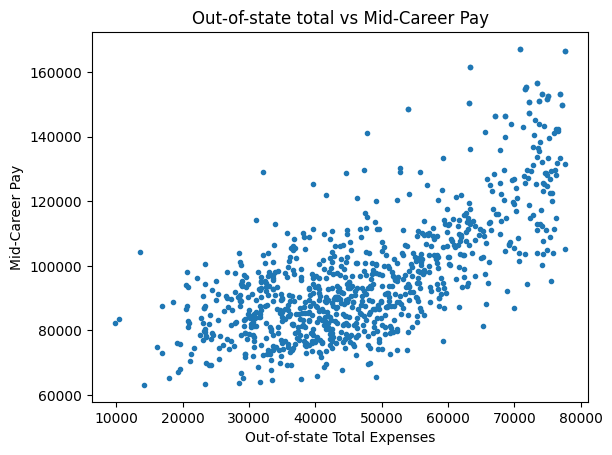

In [ ]:
plt.plot(df["Out-of-state total"], df["Mid-Career Pay"], ".")
plt.title("Out-of-state total vs Mid-Career Pay")
plt.xlabel("Out-of-state Total Expenses")
plt.ylabel("Mid-Career Pay")

From this plot, we can see a clear positive (almost linear) correlation between Mid-Career Pay and Out-of-state Total Expenses. 

This relationship tells us that as the Out-of-state Total Expenses increase, the Mid-Career Pay of a student increases.

Next we plot and examine Mid-Career Pay vs College Ranking:

Text(0, 0.5, 'Mid-Career Pay')

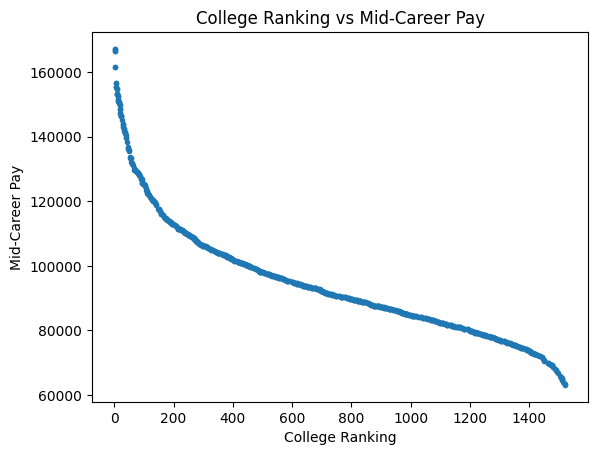

In [ ]:
plt.plot(df["Rank"], df["Mid-Career Pay"], ".")
plt.title("College Ranking vs Mid-Career Pay")
plt.xlabel("College Ranking")
plt.ylabel("Mid-Career Pay")

From this plot we can see a clear correlation between Mid-Career Pay and College Ranking, which is a cubic function (higher ranking = higher pay).

This plot supports our hypothesis that better schools will contribute to a better future salary and shows that as College Ranking increases (ranking gets worse), the Mid-Career Pay decreases.


Again, we can plot the same plot, but add in Early Career Pay in order to visual the difference between Early Career Pay and Mid-Career Pay.

We would expect that these two sets of data are very similar as a high Early Career Pay would indicate a high Mid-Career Pay.

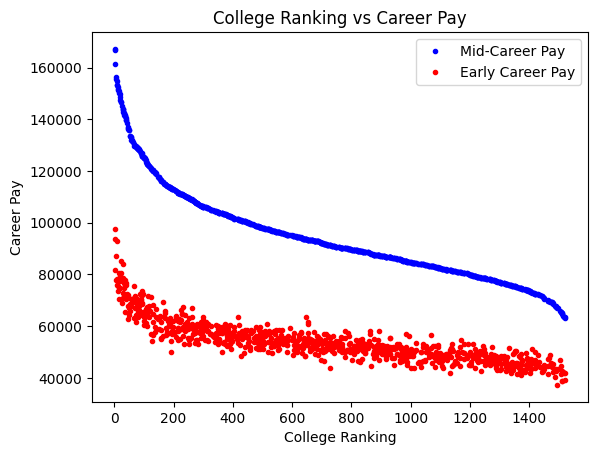

In [ ]:
plt.plot(df["Rank"], df["Mid-Career Pay"], ".", color="blue", label="Mid-Career Pay")
plt.plot(df["Rank"], df["Early Career Pay"], ".", color="red", label="Early Career Pay")
plt.title("College Ranking vs Career Pay")
plt.xlabel("College Ranking")
plt.ylabel("Career Pay")
plt.legend()
plt.show()

As expected, we can see that they seem to be dependent upon one another as they show a similar pattern

We then create a plot that compares College Ranking with Out-of-state Total Expenses, then we will include another plot that will add on In-state Total Expenses as well

Text(0, 0.5, 'Out-of-state Total Expenses')

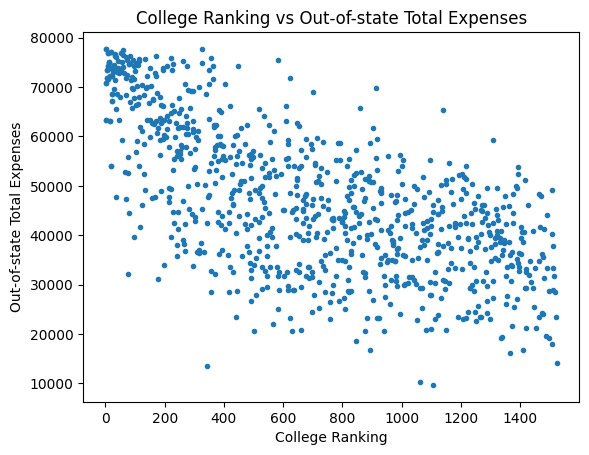

In [ ]:
plt.plot(df["Rank"], df["Out-of-state total"], ".")
plt.title("College Ranking vs Out-of-state Total Expenses")
plt.xlabel("College Ranking")
plt.ylabel("Out-of-state Total Expenses")

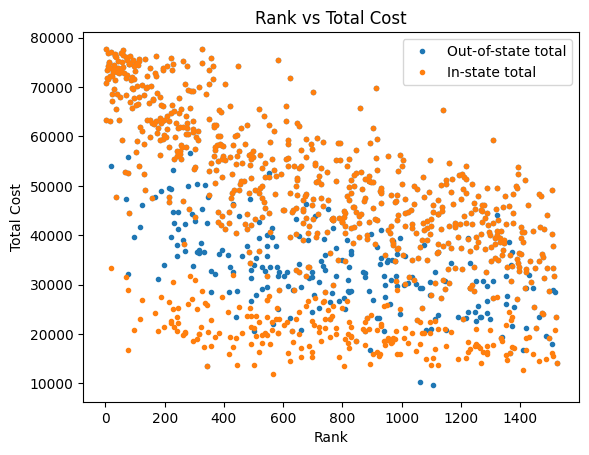

In [ ]:
plt.plot(df['Rank'], df['Out-of-state total'], ".", label="Out-of-state total")
plt.plot(df['Rank'], df['In-state total'], ".", label="In-state total")
plt.title("College Rank vs Total Costs")
plt.xlabel("Rank")
plt.ylabel("Total Cost")
plt.legend()

From this plot we can see a negative correlation between Out-of-state Total Expenses and College Ranking, which is nearly linear (higher ranking = higher expenses). 

In this plot we can see that as College Ranking increases (ranking gets worse), the Out-of-state Total Expenses decreases. This relationship suggests that better schools often have more expenseive Out-of-state Total Expenses.

On the other hand, In-state Total Expenses shows a similar pattern, although it is unclear whether or not there is dependency or correlation between In-state and Out-of-state Total Expenses. 

We then will graph out Mid-Career Pay vs % High Meaning. The % High Meaning column reveals what percent of alumni claim that their current career makes the world a better place. 

Text(0, 0.5, '% High Meaning')

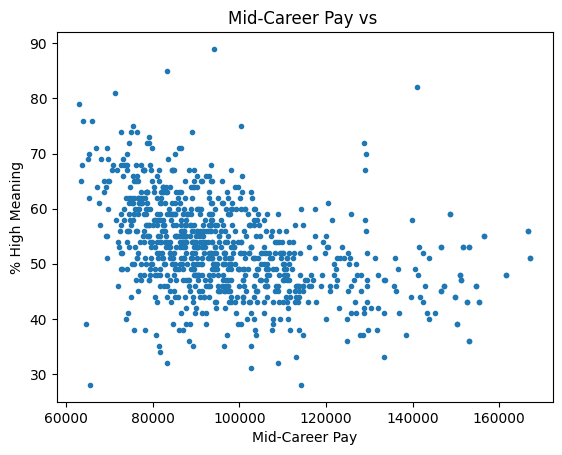

In [ ]:
plt.plot(df["Mid-Career Pay"], df["% High Meaning"], ".")
plt.title("Mid-Career Pay vs % High Meaning")
plt.xlabel("Mid-Career Pay")
plt.ylabel("% High Meaning")

From this plot, we can observe a downward, nearly linear downward trend in % of alumnis claiming their work makes the world a better place in relation to increase in mid-career pay.

This plot shows that as Mid-Career Pay increase, the % of alumnis claiming that their work makes the world a better place decreases.

This plot will plot out Mid-Career Pay vs % STEM Degrees, or what percent of students choose to attain a STEM Degree from a certain university

Text(0, 0.5, '% STEM Degrees')

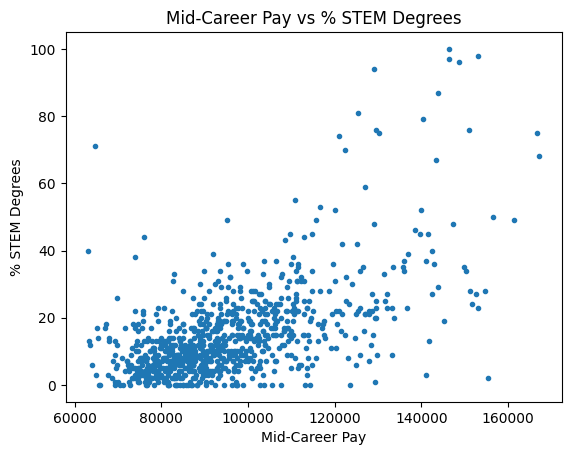

In [ ]:
plt.plot(df["Mid-Career Pay"], df["% STEM Degrees"], ".")
plt.title("Mid-Career Pay vs % STEM Degrees")
plt.xlabel("Mid-Career Pay")
plt.ylabel("% STEM Degrees")

From this plot, we can observe a positive, nearly linear trend in % of alumnis claiming their work makes the world a better place in relation to increase in mid-career pay.

This plot shows that as Mid-Career Pay increase, the % STEM Degree increases as well.

Finally, we plot the mean pay in each state with a bargraph.

We included two plots: One that compares by the Mid-Career Pay, which the other one includes both Mid-Career Pay and Early Career Pay

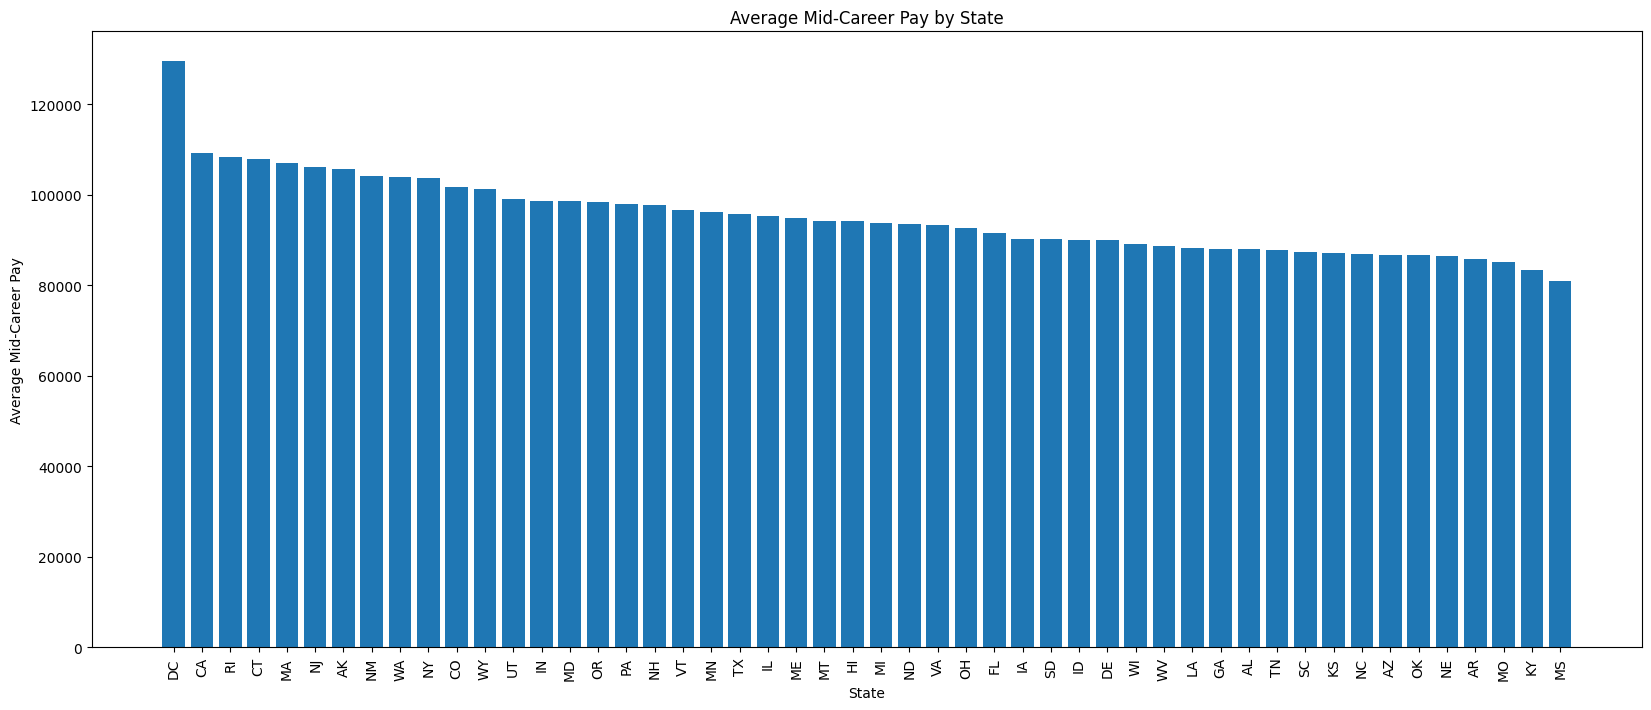

In [ ]:
fig = plt.figure(figsize=(20, 8))
state_mean_pay = df.groupby('State')['Mid-Career Pay'].mean().reset_index()

# Sort by mean mid-career pay
state_mean_pay = state_mean_pay.sort_values(by='Mid-Career Pay', ascending=False)

# Plot bar chart of mean mid-career pay by state
plt.bar(state_mean_pay['State'], state_mean_pay['Mid-Career Pay'])
plt.title("Average Mid-Career Pay by State")
plt.xlabel("State")
plt.ylabel("Average Mid-Career Pay")
plt.xticks(rotation=90)
plt.show()

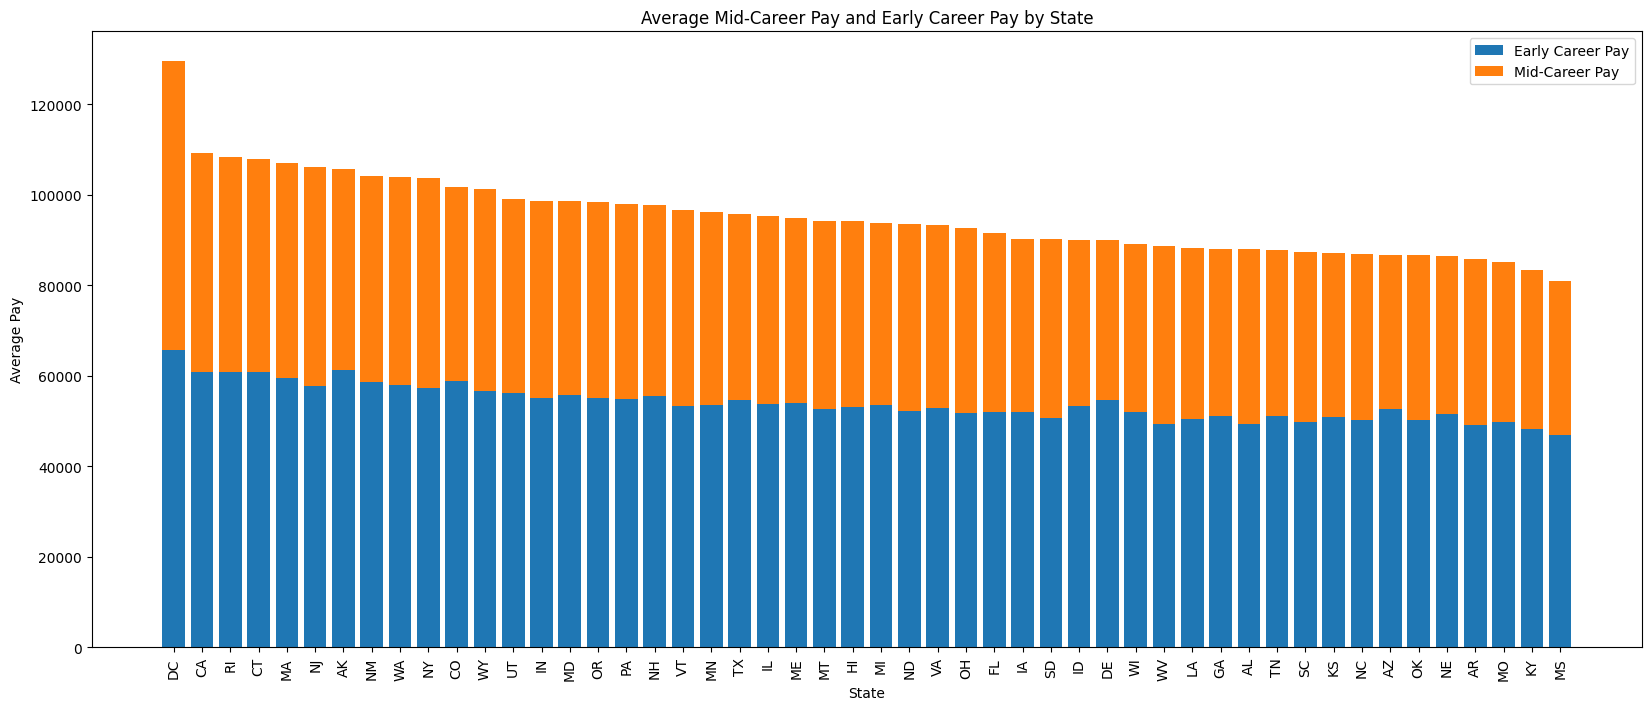

In [ ]:
fig = plt.figure(figsize=(20, 8))
state_mean_pay = df.groupby('State')[['Mid-Career Pay', 'Early Career Pay']].mean().reset_index()

state_mean_pay = state_mean_pay.sort_values(by='Mid-Career Pay', ascending=False)
# Subtract value in order to merge together later
state_mean_pay['Mid-Career Pay'] = state_mean_pay['Mid-Career Pay'] - state_mean_pay['Early Career Pay']

plt.bar(state_mean_pay['State'], state_mean_pay['Early Career Pay'], label='Early Career Pay')
plt.bar(state_mean_pay['State'], state_mean_pay['Mid-Career Pay'], bottom=state_mean_pay['Early Career Pay'], label='Mid-Career Pay')
plt.title("Average Mid-Career Pay and Early Career Pay by State")
plt.xlabel("State")
plt.ylabel("Average Pay")
plt.xticks(rotation=90)
plt.legend()
plt.show()


## Modeling and Analysis

After examining the plots above, we decide to attempt fitting linear regression models to the two pairs of relationships that appear linear, which are Mid-Career Pay vs Out-of-state Total Expenses and Out-of-state Total Expenses vs College Ranking

We begin by fitting a linear regression model Mid-Career Pay vs Out-of-state Total Expenses:

Text(0, 0.5, 'Mid-Career Pay')

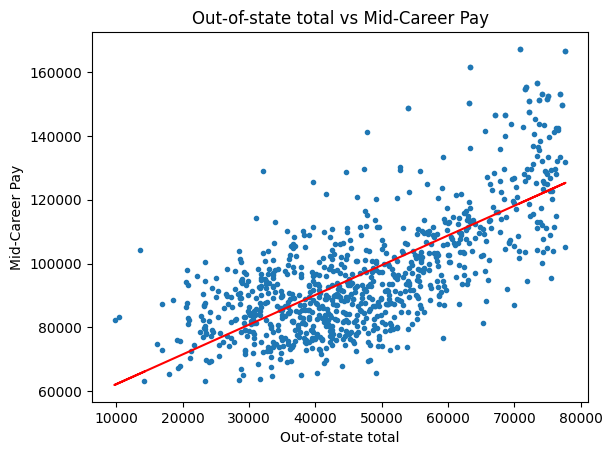

In [ ]:
regression = linear_model.LinearRegression()
x = [[x] for x in df['Out-of-state total'].values]
y = [[y] for y in df['Mid-Career Pay'].values]
model = regression.fit(x, y)
pred = model.predict(x)

plt.plot(df['Out-of-state total'], df['Mid-Career Pay'], ".")
plt.plot(df['Out-of-state total'], pred, color='r')
plt.title("Out-of-state total vs Mid-Career Pay")
plt.xlabel("Out-of-state total")
plt.ylabel("Mid-Career Pay")

From this graph, we could see that the linear regression line fits nicely, with a coefficient of about 0.93056 dollar increase for each dollar spent in annual tuition

In [ ]:
print(model.coef_)

[[0.93056192]]


In order to test to see if there is a relationship between Mid-Career Pay and Out-of-state Total Expense, we decided to run a T test with an &alpha; value of 0.05.

The Hyotheses are: 


H<sub>0</sub>: x1 = 0

H<sub>A</sub>: x1 &ne; 0

The tests statistic will be the T value of x1, which is 29.478 and the p value corresponding to it, which is 0.000.

conclusion: 
By examining the p-value (0.000 < 0.05), we reject the null hypothesis of no relationship between Mid-Career Pay and Out-of-state Total Expenses

In [ ]:
x2 = sma.add_constant(x)
est = sma.OLS(y, x2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     869.0
Date:                Fri, 12 May 2023   Prob (F-statistic):          1.77e-133
Time:                        18:55:56   Log-Likelihood:                -9699.0
No. Observations:                 884   AIC:                         1.940e+04
Df Residuals:                     882   BIC:                         1.941e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.298e+04   1567.484     33.800      0.000    4.99e+04    5.61e+04
x1             0.9306      0.032     29.478      0.000       0.869       0.993
==============================================================================
Omnibus:                       66.186   Durbin-Watson:                   1.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.911
Skew:                           0.676   Prob(JB):                     2.69e-18
Kurtosis:                       3.608   Cond. No.                     1.64e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We then move on to fitting a linear regression model on Mid-Career Pay vs College Ranking:




Text(0, 0.5, 'Mid-Career Pay')

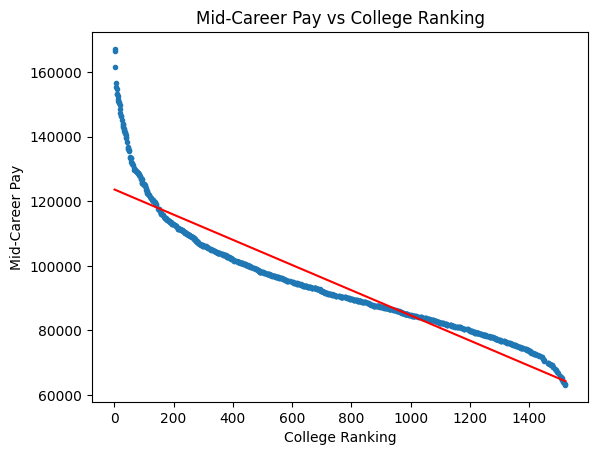

In [ ]:
x = [[x] for x in df['Rank'].values]
y = [[y] for y in df['Mid-Career Pay'].values]
model = regression.fit(x, y)
pred = model.predict(x)

plt.plot(df['Rank'], df['Mid-Career Pay'], ".")
plt.plot(df['Rank'], pred, color='r')
plt.title("Mid-Career Pay vs College Ranking")
plt.xlabel("College Ranking")
plt.ylabel("Mid-Career Pay")

As we can observe, the relationship between Mid-Career Pay and College Rank does not seem linear, which mean we should try a different type of fit for our dataset.

We attempted to refit our model with a polynomial curve, and in order to do so, we had to import two new libraries:

[LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

[PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

We decided to do a Polynomial fit with a cubic equation since we observe that there seems to be two points of inflection.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

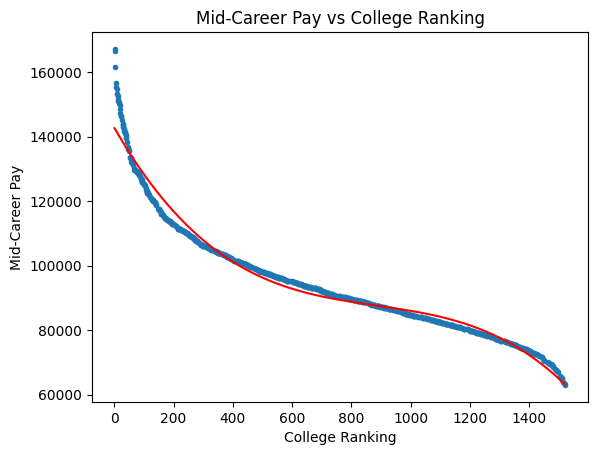

In [ ]:
x = [[x] for x in df['Rank'].values]
y = [[y] for y in df['Mid-Career Pay'].values]

poly = PolynomialFeatures(degree=3)
x_poly = poly.fit_transform(x)

reg = sma.OLS(y, x_poly).fit()
pred = reg.predict(x_poly)

plt.plot(df['Rank'], df['Mid-Career Pay'], ".")
plt.plot(df['Rank'], pred, color='r')
plt.title("Mid-Career Pay vs College Ranking")
plt.xlabel("College Ranking")
plt.ylabel("Mid-Career Pay")
plt.show()

In [ ]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 1.189e+04
Date:                Fri, 12 May 2023   Prob (F-statistic):               0.00
Time:                        21:09:54   Log-Likelihood:                -8085.4
No. Observations:                 864   AIC:                         1.618e+04
Df Residuals:                     860   BIC:                         1.620e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.428e+05    351.908    405.738      0.000    1.42e+05    1.43e+05
x1          -160.3149      2.096    -76.477      0.000    -164.429    -156.201
x2             0.1660      0.003     50.255      0.000       0.160       0.172
x3         -6.245e-05   1.46e-06    -42.761      0.000   -6.53e-05   -5.96e-05
==============================================================================
Omnibus:                      581.138   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12774.097
Skew:                           2.713   Prob(JB):                         0.00
Kurtosis:                      21.039   Cond. No.                     4.48e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.48e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In order to test to see if there is a cubic relationship between College Ranking and Mid-Career pay, we decided to run a T test with an α value of 0.05 on x3.

The Hyotheses are:

H0: x3 = 0

HA: x3 ≠ 0

The tests statistic will be the T value of x3, which is -42.761 and the p value corresponding to it, which is 0.000.

Conclusion: By examining the p-value(0.000 < 0.05), we reject the null hypothesis and state that there is a cubic relationship between College Ranking and Mid-Career pay.

Now we move on to fitting a linear regression model on College Ranking vs Out-of-state Total Expenses:

Text(0, 0.5, 'Out-of-state total')

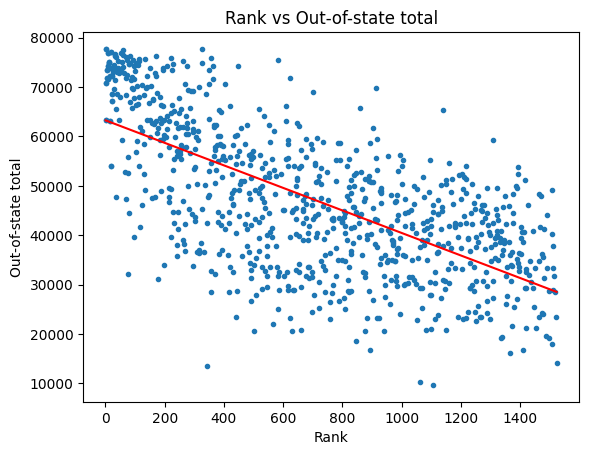

In [ ]:
x = [[x] for x in df['Rank'].values]
y = [[y] for y in df['Out-of-state total'].values]
model = regression.fit(x, y)
pred = model.predict(x)

plt.plot(df['Rank'], df['Out-of-state total'], ".")
plt.plot(df['Rank'], pred, color='r')
plt.title("Rank vs Out-of-state total")
plt.xlabel("Rank")
plt.ylabel("Out-of-state total")

From this graph, we can see that there's a linear relationship between College Ranking and Out-of-state Total Expenses at about 22.79 more per increase in rank (smaller number)

In [ ]:
print(model.coef_)

[[-22.79432486]]


Similarly, in order to test to see if there is a relationship between College Ranking and Out-of-state Total Expense, we decided to run a T test with an &alpha; value of 0.05.

The Hyotheses are: 


H<sub>0</sub>: x1 = 0

H<sub>A</sub>: x1 &ne; 0

The tests statistic will be the T value of x1, which is -26.824 and the p value corresponding to it, which is 0.000.

Conclusion: 
By examining the p-value(0.000 < 0.05), we reject the null hypothesis of no relationship between College Ranking and Out-of-state Total Expenses

In [ ]:
x2 = sma.add_constant(x)
est = sma.OLS(y, x2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     719.6
Date:                Fri, 12 May 2023   Prob (F-statistic):          2.24e-116
Time:                        18:56:11   Log-Likelihood:                -9492.3
No. Observations:                 884   AIC:                         1.899e+04
Df Residuals:                     882   BIC:                         1.900e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.325e+04    702.386     90.054      0.000    6.19e+04    6.46e+04
x1           -22.7943      0.850    -26.824      0.000     -24.462     -21.127
==============================================================================
Omnibus:                       27.299   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.100
Skew:                          -0.413   Prob(JB):                     7.91e-07
Kurtosis:                       2.717   Cond. No.                     1.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Finally, we test for the correlation between % of alumnis claiming their work makes the world a better place in relation to Mid-Career pay

Text(0, 0.5, '% High Meaning')

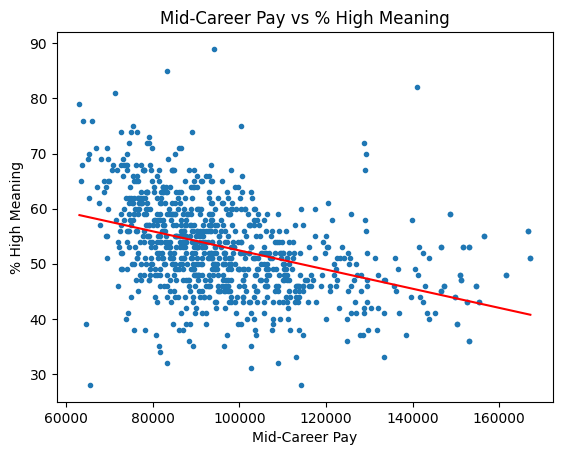

In [ ]:
x = [[x] for x in df['Mid-Career Pay'].values]
y = [[y] for y in df['% High Meaning'].values]
model = regression.fit(x, y)
pred = model.predict(x)

plt.plot(df['Mid-Career Pay'], df['% High Meaning'], ".")
plt.plot(df['Mid-Career Pay'], pred, color='r')
plt.title("Mid-Career Pay vs % High Meaning")
plt.xlabel("Mid-Career Pay")
plt.ylabel("% High Meaning")

From this graph, we observe that there's a negative relationship in Mid-Career Pay and % High meaning at about -0.000174% of alumnis claiming their work make the world a better place per dollar increase in Mid-Career Pay (-1.74% per $10000 increase).

In [ ]:
print(model.coef_)

[[-0.00017377]]


In order to test to see if there is a relationship between Mid-Career Pay and % High meaning, we run a T test with an α value of 0.05.

The Hyotheses are:

H0: x1 = 0

HA: x1 ≠ 0

The tests statistic will be the T value of x1, which is -13.184 and the p value corresponding to it, which is 0.000.

conclusion: 

By examining the p-value(0.000 < 0.05), we reject the null hypothesis of no relationship between Mid-Career Pay and % High Meaning

In [ ]:
x2 = sma.add_constant(x)
est = sma.OLS(y, x2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     173.8
Date:                Fri, 12 May 2023   Prob (F-statistic):           2.32e-36
Time:                        18:56:36   Log-Likelihood:                -3066.5
No. Observations:                 884   AIC:                             6137.
Df Residuals:                     882   BIC:                             6146.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.7941      1.305     53.472      0.000      67.232      72.356
x1            -0.0002   1.32e-05    -13.184      0.000      -0.000      -0.000
==============================================================================
Omnibus:                       35.766   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.425
Skew:                           0.247   Prob(JB):                     1.88e-16
Kurtosis:                       4.312   Cond. No.                     4.94e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now that we established that there were certain relationships between variables, we decided to try and fit our dataset into a linear regression with all the data together. We plan to create two fits: 

one with Early Career Pay and one with Mid-Career Pay


In order to fit our dataset, we imported the necessary libraries

We chose to fit models with [R-style formulas](https://www.statsmodels.org/devel/example_formulas.html) to include all the different variables as well the interactions we wished to include

In [ ]:
import statsmodels.formula.api as smf
df.head()

,Rank,School Name,Early Career Pay,Mid-Career Pay,% High Meaning,% STEM Degrees,State,In-state total,Out-of-state total
0,1,Massachusetts Institute of Technology,93700,167200,51,68,MA,70770,70770
2,2,Harvey Mudd College,97700,166600,56,75,CA,77589,77589
4,3,Princeton University,81800,161500,48,49,NJ,63294,63294
6,5,Stanford University,87100,156500,55,50,CA,73424,73424
8,7,Babson College,77800,155400,43,2,MA,71810,71810


In order to fit our dataset into a regression model, we had to rename some of the columns to get rid of spaces and better read into a formula. We also divided meaning and stem by 100 to better represent the percentage

In [ ]:
df = df.rename(columns = {'Early Career Pay': 'early_pay', 'Mid-Career Pay': 'mid_pay', '% High Meaning': 'meaning', '% STEM Degrees': 'stem', 'In-state total': 'in_total', 'Out-of-state total': 'out_total', 'Rank' : 'rank'})
df['meaning'] = df['meaning'] / 100
df['stem'] = df['stem'] / 100
df.head()

,rank,School Name,early_pay,mid_pay,meaning,stem,State,in_total,out_total
0,1,Massachusetts Institute of Technology,93700,167200,0.0051,0.0068,MA,70770,70770
2,2,Harvey Mudd College,97700,166600,0.0056,0.0075,CA,77589,77589
4,3,Princeton University,81800,161500,0.0048,0.0049,NJ,63294,63294
6,5,Stanford University,87100,156500,0.0055,0.0050,CA,73424,73424
8,7,Babson College,77800,155400,0.0043,0.0002,MA,71810,71810


Since we knew that early_pay/mid_pay and in_total/out_total could be dependent with each other, we chose to run a VIF see if there is any multicollinearity

To do so, we imported the [Varience Inflation Factor library](https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df[['in_total', 'out_total', 'meaning', 'stem', 'rank']]
vifX = pd.DataFrame()
vifX["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vifX["Predictor"] = X.columns
vifX


,VIF Factor,Predictor
0,65.747983,in_total
1,99.295148,out_total
2,24.853531,meaning
3,2.901235,stem
4,7.321716,rank


In [ ]:
Y = df[['early_pay', 'mid_pay']]
vifY = pd.DataFrame()
vifY["VIF Factor"] = [variance_inflation_factor(Y.values, i) for i in range(Y.shape[1])]
vifY["Predictor"] = Y.columns
vifY

,VIF Factor,Predictor
0,172.083476,early_pay
1,172.083476,mid_pay


Typically, a VIF factor of more than 10 indicates multicollinearity, and we can clearly see that the pay and total values have a VIF factor well over 10, which means we should remove one of each. Although the common practice is to remove the highest value, we chose to keep the variables that we deemed more important

Since Mid Career pay is often the job/income you end up with, which is also more stable, we decided to cut early_pay and stick with early_pay. 

For In-state and Out-of-state tuition, we decided that Out-of-state tuition makes more sense as many school make qualify education cheaper for their state residents (Ex. UT Austin, UMass Amherst, UMD)

Then we will rerun the VIF test until there is no more multicollinearity

In [ ]:
X2 = df[['out_total', 'meaning', 'stem', 'rank']]
vif2 = pd.DataFrame()
vif2["VIF Factor"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif2["Predictor"] = X2.columns
vif2

,VIF Factor,Predictor
0,9.729412,out_total
1,22.431146,meaning
2,2.797157,stem
3,7.199705,rank


We will remove meaning as a VIF Factor of 22 is greater than 10

In [ ]:
X3 = df[['out_total', 'stem', 'rank']]
vif3 = pd.DataFrame()
vif3["VIF Factor"] = [variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])]
vif3["Predictor"] = X3.columns
vif3

,VIF Factor,Predictor
0,4.110476,out_total
1,2.537506,stem
2,2.124486,rank


Now that we determined that there was no multicollinearity, we can proceed and create a linear regression model with the addition of the interactions

In [ ]:
formula = "mid_pay ~ out_total + rank + stem"
reg = smf.ols(formula = formula, data=df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                mid_pay   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     2500.
Date:                Sat, 13 May 2023   Prob (F-statistic):               0.00
Time:                        00:13:43   Log-Likelihood:                -8722.3
No. Observations:                 864   AIC:                         1.745e+04
Df Residuals:                     860   BIC:                         1.747e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.067e+05   1262.446     84.541      0.000    1.04e+05    1.09e+05
out_total      0.1761      0.018      9.830      0.000       0.141       0.211
rank         -31.5308      0.662    -47.662      0.000     -32.829     -30.232
stem        2.214e+06   1.64e+05     13.513      0.000    1.89e+06    2.54e+06
==============================================================================
Omnibus:                      404.255   Durbin-Watson:                   0.485
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2900.267
Skew:                           1.998   Prob(JB):                         0.00
Kurtosis:                      11.037   Cond. No.                     4.03e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.03e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

By looking at the summary of our fitted model, we say that all variables are significant to the model.

##Conclusion

With our final equation for our model, we can see that variables Rank, obtaining a stem degree, and cost of tuition attribute to the future salary of a student. Our final fitted model:

mid_pay = 106700 + 0.1761out_total - 31.5308rank + 2214000stem*

From our model, we can see that for every 1 dollar increase in Out-of-state tuition, there is a 0.1761 dollar increase in future mid-career pay. 
For every 1 rank increase in rank (as rank gets worse), there is a 31.53 dollar decrease in future mid-career pay.
For every 1 percent increase in percentage of students who obtained a stem degree from a college, there is a 2214000/100 = 22140 dollar increase in mid-career pay.

Through our analysis, we found that the expensive tuition and prestigous rankings do correlate to better pay for a student's future, and that STEM majors are often paid more in the future.

College is an important time for many students to further their education, and the pricing, prestigion and area to concentrate in are all factors that go into a student's decision. Through our tutorial, we found correlations and relationships between these variables. However, this tutorial is merely a simplification of the decisions, and often correlation does not mean causation, and there are many more factors that can attribute whichever college is most suited for a specific student.